# Stanford Dogs — Phase 2
## CNN Variant B: **5 Conv Blocks (Depth Increase)**

**Tek değişiklik:** Conv block sayısı **5** yapıldı.
- Filtre dizisi: **32 → 64 → 128 → 256 → 256**

Diğer her şey baseline ile aynı (Adam, LR=1e-3, batch=32, augmentation, BN, dropout).

In [1]:
# =========================
# Imports & Environment
# =========================
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import csv
import tarfile
import urllib.request
import shutil
from scipy.io import loadmat
from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow version:", tf.__version__)
print("Devices:", tf.config.list_physical_devices())


TensorFlow version: 2.19.0
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# ==========================================
# CONFIG
# ==========================================
BASE_CONFIG = {
    "BASE_DIR": "/content/datasets/stanford_dogs",
    "SPLIT_FOLDER": "stanford_dogs_split",

    "IMG_SIZE": 128,
    "VAL_SPLIT": 0.1,
    "AUTOTUNE": tf.data.AUTOTUNE,

    "EPOCHS": 20,
    "EARLY_STOP": True,
    "EARLY_STOP_PATIENCE": 5,

    "SEED": 42,
}

CNN_CONFIG = {
    "ID": "CNN_VARIANT_B_5BLOCKS",
    "BATCH_SIZE": 32,
    "LEARNING_RATE": 1e-3,
    "OPTIMIZER": "adam",
    "DROPOUT": 0.3,
    "USE_BATCHNORM": True,
    "AUGMENT": True,
}

CONFIG = BASE_CONFIG.copy()
CONFIG.update(CNN_CONFIG)

os.makedirs(CONFIG["BASE_DIR"], exist_ok=True)

SEED = CONFIG["SEED"]
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Active CONFIG:")
for k in sorted(CONFIG.keys()):
    print(f"  {k}: {CONFIG[k]}")


Active CONFIG:
  AUGMENT: True
  AUTOTUNE: -1
  BASE_DIR: /content/datasets/stanford_dogs
  BATCH_SIZE: 32
  DROPOUT: 0.3
  EARLY_STOP: True
  EARLY_STOP_PATIENCE: 5
  EPOCHS: 20
  ID: CNN_VARIANT_B_5BLOCKS
  IMG_SIZE: 128
  LEARNING_RATE: 0.001
  OPTIMIZER: adam
  SEED: 42
  SPLIT_FOLDER: stanford_dogs_split
  USE_BATCHNORM: True
  VAL_SPLIT: 0.1


In [3]:
# ==========================================
# DATASET DOWNLOAD & PREPARATION (IF NEEDED)
# ==========================================
IMAGES_URL = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
LISTS_URL  = "http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar"

def download_if_not_exists(url, dest_path):
    if os.path.exists(dest_path):
        print(f"[INFO] File exists: {dest_path}")
        return
    print(f"[INFO] Downloading {url} -> {dest_path}")
    urllib.request.urlretrieve(url, dest_path)
    print("[INFO] Downloaded.")

def extract_if_not_exists(tar_path, extract_to):
    os.makedirs(extract_to, exist_ok=True)
    print(f"[INFO] Extracting {tar_path} -> {extract_to}")
    with tarfile.open(tar_path) as tar:
        tar.extractall(extract_to)
    print("[INFO] Extracted.")

def create_train_test_split(base_dir, split_folder="stanford_dogs_split"):
    split_dir = os.path.join(base_dir, split_folder)
    if os.path.exists(split_dir):
        print(f"[INFO] Split exists: {split_dir}")
        return split_dir

    images_dir = os.path.join(base_dir, "Images")
    train_mat_path = os.path.join(base_dir, "train_list.mat")
    test_mat_path  = os.path.join(base_dir, "test_list.mat")

    if not os.path.exists(images_dir):
        raise FileNotFoundError(f"Missing Images dir: {images_dir}")
    if not (os.path.exists(train_mat_path) and os.path.exists(test_mat_path)):
        raise FileNotFoundError("Missing train_list.mat or test_list.mat")

    os.makedirs(split_dir, exist_ok=True)
    train_root = os.path.join(split_dir, "train")
    test_root  = os.path.join(split_dir, "test")
    os.makedirs(train_root, exist_ok=True)
    os.makedirs(test_root, exist_ok=True)

    train_mat = loadmat(train_mat_path)
    test_mat  = loadmat(test_mat_path)

    def mat_to_list(mat):
        out = []
        for i in range(mat.shape[0]):
            x = mat[i][0]
            while isinstance(x, np.ndarray):
                x = x[0]
            out.append(str(x))
        return out

    train_files = mat_to_list(train_mat["file_list"])
    train_labels = train_mat["labels"].reshape(-1)
    test_files = mat_to_list(test_mat["file_list"])
    test_labels = test_mat["labels"].reshape(-1)

    print("[INFO] Copying train images...")
    for p, l in zip(train_files, train_labels):
        c = f"class_{int(l):03d}"
        dst_dir = os.path.join(train_root, c)
        os.makedirs(dst_dir, exist_ok=True)
        src = os.path.join(images_dir, p)
        dst = os.path.join(dst_dir, os.path.basename(p))
        if not os.path.exists(dst):
            shutil.copy(src, dst)

    print("[INFO] Copying test images...")
    for p, l in zip(test_files, test_labels):
        c = f"class_{int(l):03d}"
        dst_dir = os.path.join(test_root, c)
        os.makedirs(dst_dir, exist_ok=True)
        src = os.path.join(images_dir, p)
        dst = os.path.join(dst_dir, os.path.basename(p))
        if not os.path.exists(dst):
            shutil.copy(src, dst)

    print(f"[INFO] Split created: {split_dir}")
    return split_dir

def prepare_stanford_dogs_dataset(base_dir, split_folder):
    os.makedirs(base_dir, exist_ok=True)

    images_tar_path = os.path.join(base_dir, "images.tar")
    lists_tar_path  = os.path.join(base_dir, "lists.tar")

    download_if_not_exists(IMAGES_URL, images_tar_path)
    download_if_not_exists(LISTS_URL,  lists_tar_path)

    if not os.path.exists(os.path.join(base_dir, "Images")):
        extract_if_not_exists(images_tar_path, base_dir)
    else:
        print("[INFO] Images already extracted.")

    train_mat_path = os.path.join(base_dir, "train_list.mat")
    test_mat_path  = os.path.join(base_dir, "test_list.mat")
    if not (os.path.exists(train_mat_path) and os.path.exists(test_mat_path)):
        extract_if_not_exists(lists_tar_path, base_dir)
    else:
        print("[INFO] List .mat files already present.")

    create_train_test_split(base_dir, split_folder)

prepare_stanford_dogs_dataset(CONFIG["BASE_DIR"], CONFIG["SPLIT_FOLDER"])


[INFO] Downloading http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar -> /content/datasets/stanford_dogs/images.tar
[INFO] Downloaded.
[INFO] Downloading http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar -> /content/datasets/stanford_dogs/lists.tar
[INFO] Downloaded.
[INFO] Extracting /content/datasets/stanford_dogs/images.tar -> /content/datasets/stanford_dogs


/tmp/ipython-input-2084886005.py:19: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(extract_to)


[INFO] Extracted.
[INFO] Extracting /content/datasets/stanford_dogs/lists.tar -> /content/datasets/stanford_dogs
[INFO] Extracted.
[INFO] Copying train images...
[INFO] Copying test images...
[INFO] Split created: /content/datasets/stanford_dogs/stanford_dogs_split


In [4]:
# ==========================================
# DATASET LOADING
# ==========================================
SPLIT_DIR = os.path.join(CONFIG["BASE_DIR"], CONFIG["SPLIT_FOLDER"])
train_path = os.path.join(SPLIT_DIR, "train")
test_path  = os.path.join(SPLIT_DIR, "test")

train_ds_full = keras.utils.image_dataset_from_directory(
    train_path,
    labels="inferred",
    label_mode="int",
    image_size=(CONFIG["IMG_SIZE"], CONFIG["IMG_SIZE"]),
    batch_size=CONFIG["BATCH_SIZE"],
    shuffle=True,
    seed=CONFIG["SEED"],
)

class_names = train_ds_full.class_names
num_classes = len(class_names)
print("Num classes:", num_classes)

val_batches = int(len(train_ds_full) * CONFIG["VAL_SPLIT"])
val_ds = train_ds_full.take(val_batches)
train_ds = train_ds_full.skip(val_batches)

test_ds = keras.utils.image_dataset_from_directory(
    test_path,
    labels="inferred",
    label_mode="int",
    image_size=(CONFIG["IMG_SIZE"], CONFIG["IMG_SIZE"]),
    batch_size=CONFIG["BATCH_SIZE"],
    shuffle=False,
)

train_ds = train_ds.cache().prefetch(CONFIG["AUTOTUNE"])
val_ds   = val_ds.cache().prefetch(CONFIG["AUTOTUNE"])
test_ds  = test_ds.cache().prefetch(CONFIG["AUTOTUNE"])


Found 12000 files belonging to 120 classes.
Num classes: 120
Found 8580 files belonging to 120 classes.


In [5]:
# ==========================================
# CNN Variant B – 5 Conv Blocks
# ONLY CHANGE: Depth increased to 5 blocks
# Filters: 32 -> 64 -> 128 -> 256 -> 256
# ==========================================
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="data_augmentation")

def build_cnn_variant_b(input_shape, num_classes, cfg):
    use_bn = cfg["USE_BATCHNORM"]
    dropout = cfg["DROPOUT"]
    augment = cfg["AUGMENT"]

    inputs = keras.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs)
    if augment:
        x = data_augmentation(x)

    for f in [32, 64, 128, 256, 256]:
        x = layers.Conv2D(f, 3, padding="same")(x)
        if use_bn:
            x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(256)(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(dropout)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs, name=cfg["ID"])

model = build_cnn_variant_b((CONFIG["IMG_SIZE"], CONFIG["IMG_SIZE"], 3), num_classes, CONFIG)
model.summary()


Model: "CNN_VARIANT_B_5BLOCKS"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,079,096 (4.12 MB)

 Trainable params: 1,077,112 (4.11 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [6]:
# ==========================================
# Compile & Train
# ==========================================
lr = CONFIG["LEARNING_RATE"]
optimizer = keras.optimizers.Adam(learning_rate=lr)

model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

callbacks = []
if CONFIG["EARLY_STOP"]:
    callbacks.append(keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=CONFIG["EARLY_STOP_PATIENCE"],
        restore_best_weights=True
    ))

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=CONFIG["EPOCHS"],
    callbacks=callbacks,
)


Epoch 1/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 33s 68ms/step - accuracy: 0.0111 - loss: 5.0362 - val_accuracy: 0.0101 - val_loss: 4.8530
Epoch 2/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 30s 51ms/step - accuracy: 0.0233 - loss: 4.7094 - val_accuracy: 0.0228 - val_loss: 4.6971
Epoch 3/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.0341 - loss: 4.4890 - val_accuracy: 0.0270 - val_loss: 4.6647
Epoch 4/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.0424 - loss: 4.3245 - val_accuracy: 0.0490 - val_loss: 4.3731
Epoch 5/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.0570 - loss: 4.1878 - val_accuracy: 0.0372 - val_loss: 4.4170
Epoch 6/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.0704 - loss: 4.0504 - val_accuracy: 0.0422 - val_loss: 4.4543
Epoch 7/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.0829 - loss: 3.9353 - val_accuracy: 0.0245 - val_loss: 4.8112
Epoch 8/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.1011 - loss: 3.8139 - 

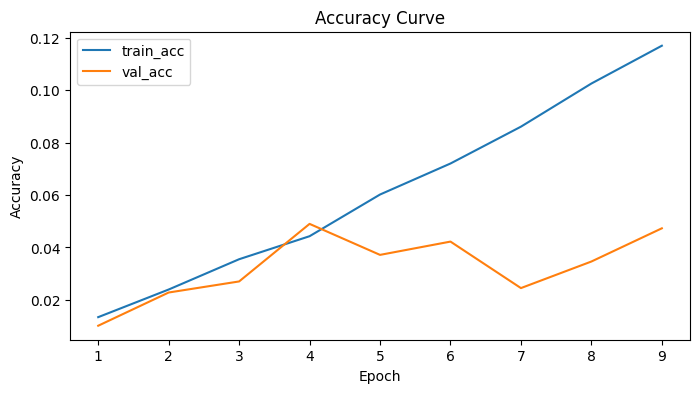

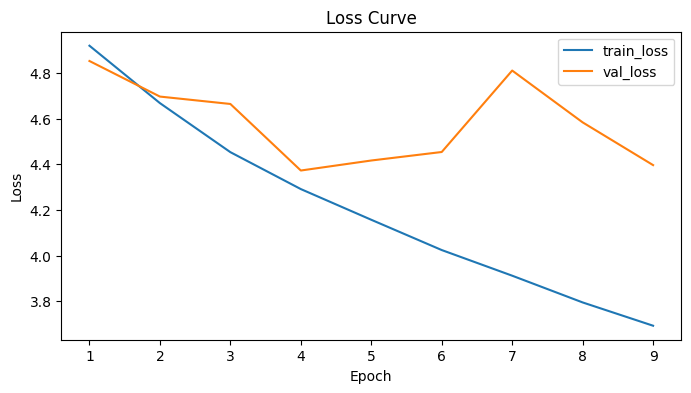

In [7]:
# ==========================================
# Learning Curves
# ==========================================
hist = history.history
epochs = range(1, len(hist["loss"]) + 1)

plt.figure(figsize=(8,4))
plt.plot(epochs, hist["accuracy"], label="train_acc")
plt.plot(epochs, hist["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(epochs, hist["loss"], label="train_loss")
plt.plot(epochs, hist["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()


In [8]:
# ==========================================
# Evaluation
# ==========================================
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acc : {test_acc:.4f}")

y_true, y_pred = [], []
for x, y in test_ds:
    p = model.predict(x, verbose=0)
    y_true.extend(y.numpy().tolist())
    y_pred.extend(np.argmax(p, axis=1).tolist())

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


Test Loss: 4.3441
Test Acc : 0.0414
              precision    recall  f1-score   support

   class_001     0.0000    0.0000    0.0000        52
   class_002     0.1277    0.1412    0.1341        85
   class_003     0.2000    0.0592    0.0914       152
   class_004     0.0000    0.0000    0.0000        49
   class_005     0.0000    0.0000    0.0000       114
   class_006     0.1296    0.6023    0.2133        88
   class_007     0.0000    0.0000    0.0000        96
   class_008     0.0000    0.0000    0.0000        72
   class_009     0.0000    0.0000    0.0000        72
   class_010     0.0000    0.0000    0.0000       139
   class_011     0.0625    0.0933    0.0749        75
   class_012     0.0000    0.0000    0.0000        95
   class_013     0.0259    0.1034    0.0415        87
   class_014     0.0000    0.0000    0.0000        71
   class_015     0.0000    0.0000    0.0000        59
   class_016     0.0000    0.0000    0.0000        53
   class_017     0.2333    0.1228    0.1609  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion matrix shape: (120, 120)


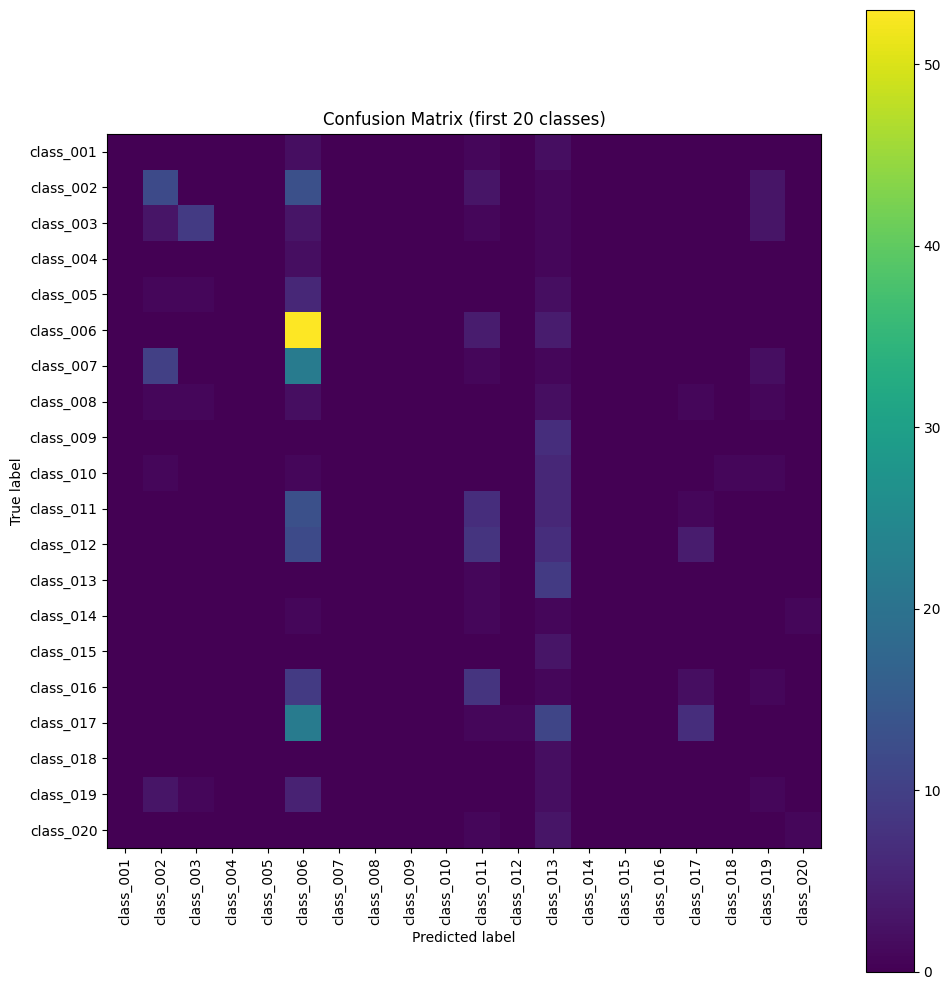

In [9]:
# ==========================================
# Confusion Matrix (plot first N classes)
# ==========================================
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix shape:", cm.shape)

N = 20
cm_small = cm[:N, :N]

plt.figure(figsize=(10,10))
plt.imshow(cm_small, interpolation="nearest")
plt.title(f"Confusion Matrix (first {N} classes)")
plt.colorbar()
tick_marks = np.arange(N)
plt.xticks(tick_marks, class_names[:N], rotation=90)
plt.yticks(tick_marks, class_names[:N])
plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()


In [10]:
# ==========================================
# Save model + history
# ==========================================
os.makedirs("results", exist_ok=True)

model_path = f"results/{CONFIG['ID']}.keras"
model.save(model_path)
print("Saved model to:", model_path)

hist_path = f"results/{CONFIG['ID']}_history.csv"
with open(hist_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["epoch"] + list(history.history.keys()))
    for i in range(len(history.history["loss"])):
        writer.writerow([i+1] + [history.history[k][i] for k in history.history.keys()])
print("Saved history to:", hist_path)


Saved model to: results/CNN_VARIANT_B_5BLOCKS.keras
Saved history to: results/CNN_VARIANT_B_5BLOCKS_history.csv
